In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn import decomposition
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.cluster import KMeans
import timeit
import datetime
import datetime as dt
from datetime import timedelta
import pickle
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples
from sklearn.metrics import silhouette_score

In [3]:
def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
    for d1, d2 in axis_ranks:  # On affiche les 3 premiers plans factoriels, donc les 6 premières composantes
        if d2 < n_comp:

            # initialisation de la figure
            fig, ax = plt.subplots(figsize=(10, 8))

            # détermination des limites du graphique
            if lims is not None:
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30:
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else:
                xmin, xmax, ymin, ymax = min(pcs[d1, :]), max(
                    pcs[d1, :]), min(pcs[d2, :]), max(pcs[d2, :])

            # affichage des flèches
            # s'il y a plus de 30 flèches, on n'affiche pas le triangle à leur extrémité
            if pcs.shape[1] < 30:
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                           pcs[d1, :], pcs[d2, :],
                           angles='xy', scale_units='xy', scale=1, color="grey")
                # (voir la doc : https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html)
            else:
                lines = [[[0, 0], [x, y]] for x, y in pcs[[d1, d2]].T]
                ax.add_collection(LineCollection(
                    lines, axes=ax, alpha=.1, color='black'))

            # affichage des noms des variables
            if labels is not None:
                for i, (x, y) in enumerate(pcs[[d1, d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax:
                        plt.text(x, y, labels[i], fontsize='14', ha='center',
                                 va='center', rotation=label_rotation, color="blue", alpha=0.5)

            # affichage du cercle
            circle = plt.Circle((0, 0), 1, facecolor='none', edgecolor='b')
            plt.gca().add_artist(circle)

            # définition des limites du graphique
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)

            # affichage des lignes horizontales et verticales
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(
                d1+1, round(100*pca.explained_variance_ratio_[d1], 1)))
            plt.ylabel('F{} ({}%)'.format(
                d2+1, round(100*pca.explained_variance_ratio_[d2], 1)))

            plt.title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
            # plt.show(block=False)
            plt.draw()


def display_factorial_planes(X_projected, n_comp, pca, axis_ranks, labels=None, clusters=None, alpha=1, illustrative_var=None):
    for d1, d2 in axis_ranks:
        if d2 < n_comp:

            # initialisation de la figure
            fig = plt.figure(figsize=(30, 22))

            # affichage des points
            if illustrative_var is None:
                plt.scatter(X_projected[:, d1], X_projected[:, d2],
                            alpha=alpha, color='w', marker='*', s=5)
            else:
                illustrative_var = np.array(illustrative_var)
                for value in np.unique(illustrative_var):
                    selected = np.where(illustrative_var == value)
                    plt.scatter(
                        X_projected[selected, d1], X_projected[selected, d2], alpha=alpha, label=value)
                plt.legend()

            # affichage des labels des points
            if labels is not None:
                clusters_color = {0: 'red', 1: 'blue', 2: 'yellow'}
                for i, (x, y) in enumerate(X_projected[:, [d1, d2]]):
                    plt.text(x, y, labels[i], color=clusters_color[clusters[i]],
                             fontsize='20', ha='center', va='center')

            # détermination des limites du graphique
            boundary = np.max(np.abs(X_projected[:, [d1, d2]])) * 1.1
            plt.xlim([-boundary, boundary])
            plt.ylim([-boundary, boundary])

            # affichage des lignes horizontales et verticales
            #plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            #plt.plot([0, 0], [-100, 100], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(
                d1+1, round(100*pca.explained_variance_ratio_[d1], 1)), fontsize=25)
            plt.ylabel('F{} ({}%)'.format(
                d2+1, round(100*pca.explained_variance_ratio_[d2], 1)), fontsize=25)

            plt.title("Projection des individus (sur F{} et F{})".format(
                d1+1, d2+1), fontsize=35)
            # plt.show(block=False)
            plt.draw()


def display_scree_plot(pca):
    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(), c="red", marker='o')
    plt.xlabel("rang de l'axe d'inertie")
    plt.ylabel("pourcentage d'inertie")
    plt.title("Eboulis des valeurs propres")
    # plt.show(block=False)
    plt.draw()

La fonction data_sli(date_model) est parametrée pour fonctionner avec le dataset orders_data contenant une commande unique par  
ligne afin de creer un dataset de sortie contenant les variables numeriques(note_moy, Monetary, Recency et Fequency)  
relatives a chaque client(en index) sur une periode précise qui debute a la date la plus ancienne du dataset  
('2017-01-05') et termine a la date definie en entree au format '2018-08-30'(date_model)

In [4]:
def data_sli(date_model='2018-08-30'):
    now = datetime.datetime(2018, 8, 30)

    dataset = orders_data[['order_id', 'customer_id', 'customer_unique_id', 'order_item_id', 'total_price', 'review_score',
                           'order_purchase_timestamp']].copy()
    dataset['order_purchase_timestamp'] = pd.to_datetime(dataset['order_purchase_timestamp'])
    
    dataset = dataset[dataset['order_purchase_timestamp'] < date_model]
    dataset = dataset.groupby('customer_unique_id').agg(note_moy=('review_score', np.mean),
                                                        Monetary=('total_price', np.sum),
                                                        Recency=('order_purchase_timestamp', max),
                                                        Frequency=('customer_id', len))
    dataset['Recency'] = now - dataset['Recency']
    dataset['Recency'] = dataset['Recency'].dt.days
    
    return dataset

def summary(df):
    display(df.head())
    print('-'*100)
    display(df.info())
    print('-'*100)
    display(df.describe([0.01,0.25,0.50,0.75,0.99]))
    
def qualit(donnees):
    print("nb de lignes x nb de colonnes : ", donnees.shape, ".\n")
    print("% de données manquantes :\n", (donnees.isna().sum() /
          len(donnees) * 100).sort_values(ascending=False), "\n")
    print("nb de lignes dupliquées :", donnees.duplicated().sum(), ".\n")

In [5]:
orders_data = pd.read_csv(
    'orders_data.csv', delimiter=',', encoding="utf8", index_col=0)
print(orders_data.shape)
orders_data.head()

(95568, 7)


,order_id,customer_id,customer_unique_id,order_item_id,total_price,review_score,order_purchase_timestamp
0,00010242fe8c5a6d1ba2dd792cb16214,3ce436f183e68e07877b285a838db11a,871766c5855e863f6eccc05f988b23cb,1,58.90,5.0,2017-09-13 08:59:02
1,00018f77f2f0320c557190d7a144bdd3,f6dd3ec061db4e3987629fe6b26e5cce,eb28e67c4c0b83846050ddfb8a35d051,1,239.90,4.0,2017-04-26 10:53:06
2,000229ec398224ef6ca0657da4fc703e,6489ae5e4333f3693df5ad4372dab6d3,3818d81c6709e39d06b2738a8d3a2474,1,199.00,5.0,2018-01-14 14:33:31
3,00024acbcdf0a6daa1e931b038114c75,d4eb9395c8c0431ee92fce09860c5a06,af861d436cfc08b2c2ddefd0ba074622,1,12.99,4.0,2018-08-08 10:00:35
4,00042b26cf59d7ce69dfabb4e55b4fd9,58dbd0b2d70206bf40e62cd34e84d795,64b576fb70d441e8f1b2d7d446e483c5,1,199.90,5.0,2017-02-04 13:57:51


In [6]:
orders_data.order_purchase_timestamp.min(), orders_data.order_purchase_timestamp.max()

('2017-01-05 11:56:06', '2018-08-29 15:00:37')

#### Chargement de la totalité des données clients (jusqu'au 2018-8-30)

In [7]:
num_data = data_sli('2018-8-30')
print(num_data.shape)
num_data.head()

(92504, 4)


,note_moy,Monetary,Recency,Frequency
customer_unique_id,,,,
0000366f3b9a7992bf8c76cfdf3221e2,5.0,129.90,111,1
0000b849f77a49e4a4ce2b2a4ca5be3f,4.0,18.90,114,1
0000f46a3911fa3c0805444483337064,3.0,69.00,537,1
0000f6ccb0745a6a4b88665a16c9f078,4.0,25.99,321,1
0004aac84e0df4da2b147fca70cf8255,5.0,180.00,288,1


In [8]:
num_data.describe()

,note_moy,Monetary,Recency,Frequency
count,92504.000000,92504.000000,92504.000000,92504.000000
mean,4.154123,147.600478,236.099563,1.033123
std,1.279691,242.754956,150.962701,0.208324
min,1.000000,0.850000,0.000000,1.000000
25%,4.000000,48.900000,114.000000,1.000000
50%,5.000000,89.900000,218.000000,1.000000
75%,5.000000,159.770000,344.000000,1.000000
max,5.000000,13440.000000,601.000000,15.000000


In [9]:
# Centrage et Réduction
std_scale = preprocessing.StandardScaler().fit(num_data.values)
num_scaled = std_scale.transform(num_data.values)
num_normalized = pd.DataFrame(num_scaled, columns=num_data.columns.to_list())
num_normalized

,note_moy,Monetary,Recency,Frequency
0,0.661005,-0.072915,-0.828683,-0.158998
1,-0.120438,-0.530169,-0.808811,-0.158998
2,-0.901881,-0.323787,1.993221,-0.158998
3,-0.120438,-0.500963,0.562397,-0.158998
4,0.661005,0.133467,0.343798,-0.158998
...,...,...,...,...
92499,0.661005,5.859436,1.397044,-0.158998
92500,-0.120438,-0.340718,0.171569,-0.158998
92501,0.661005,-0.237692,2.198571,-0.158998
92502,0.661005,-0.134294,-0.775690,-0.158998


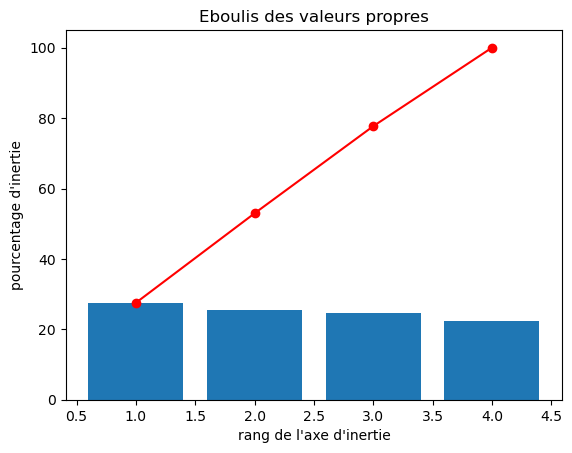

In [10]:
# choix du nombre de composantes à calculer
n_comp = 4

# selection des colonnes à prendre en compte dans l'ACP
data_pca = num_normalized

# préparation des données pour l'ACP
X = data_pca.values
names = data_pca.index  # ou data.index pour avoir les intitulés
features = data_pca.columns

# Calcul des composantes principales
pca = decomposition.PCA(n_components=n_comp)
pca.fit(X)

# Eboulis des valeurs propres
display_scree_plot(pca)

# plt.savefig("eboulis.jpg")

#### La premiere composante contient 27 % de l'information disponible et disposons de 53% avec les deux premiers facteurs.

In [11]:
# Proportion de la variance expliquée
print(pca.explained_variance_ratio_)

[0.27540414 0.25412718 0.24754099 0.22292768]


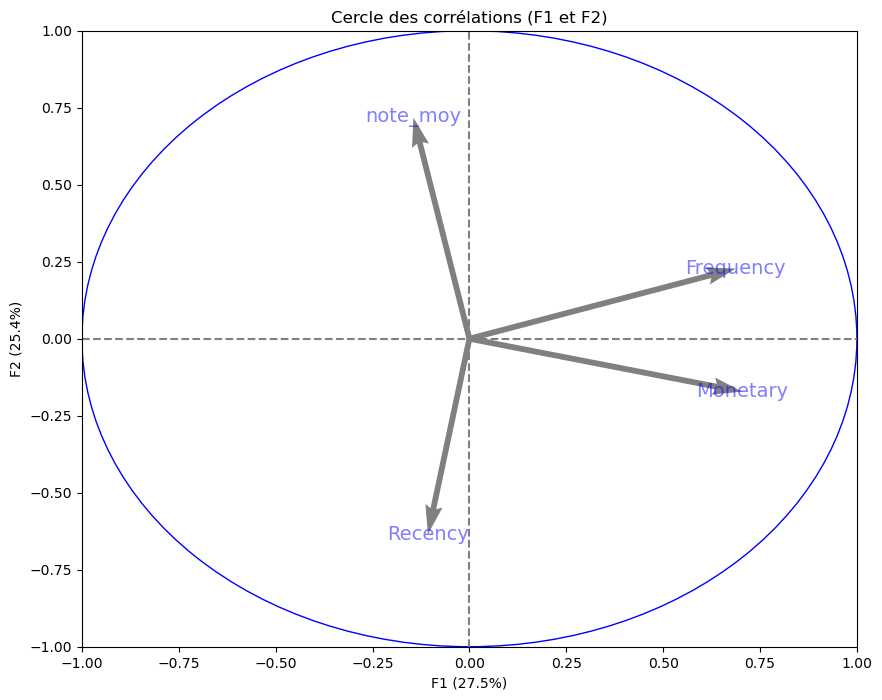

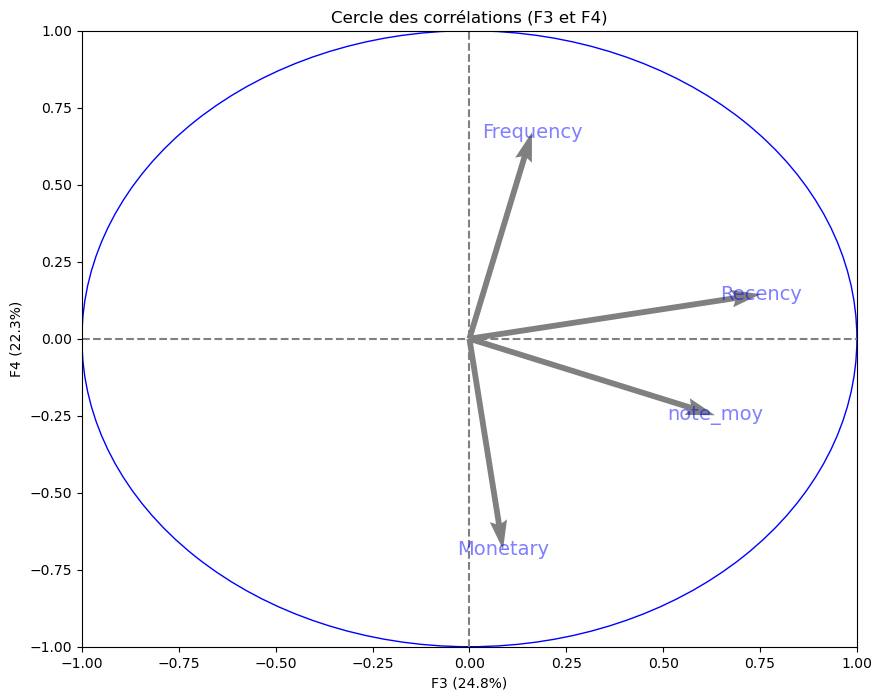

In [12]:
# Cercle des corrélations
pcs = pca.components_
display_circles(pcs, n_comp, pca, [
                (0, 1), (2, 3), (4, 5)], labels=np.array(features))

# plt.savefig("cercles.jpg")

In [13]:
X_projected = pca.transform(X)
acp_df = pd.DataFrame(X_projected)
acp_df.index = names

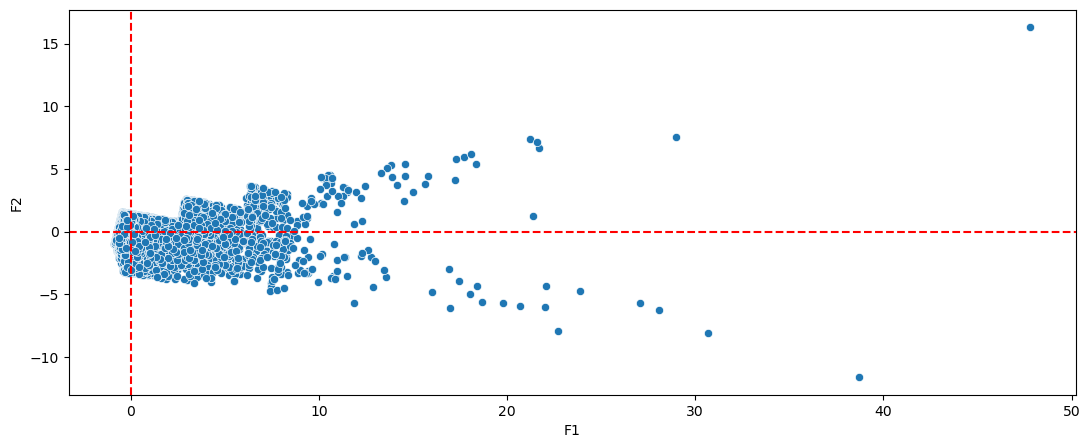

In [14]:
x = acp_df[0]
y = acp_df[1]
fig, scatter = plt.subplots(figsize=(13, 5), dpi=100)
scatter = sns.scatterplot(x=x, y=y, data=acp_df, s=35)
plt.axhline(y=0, color='r', linestyle='--')
plt.axvline(x=0, color='r', linestyle='--')
plt.xlabel("F1")
plt.ylabel("F2")
#plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.08), ncol=3)
plt.draw()

### Clusterisation KMeans

#### Choix du nombre de clusters

In [15]:
ssd = []
range_n_clusters = [1, 2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(X)
    ssd.append(kmeans.inertia_)

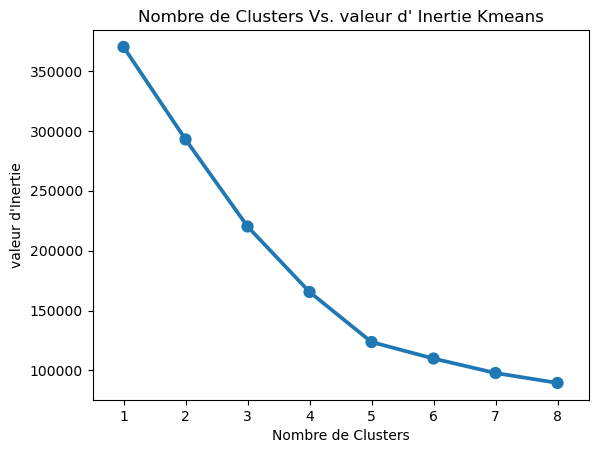

In [16]:
import seaborn as sns

sns.pointplot(x=range_n_clusters, y=ssd)
plt.xlabel('Nombre de Clusters')
plt.ylabel("valeur d'Inertie")
plt.title("Nombre de Clusters Vs. valeur d' Inertie Kmeans")
plt.draw()
#plt.savefig("coude inertie.jpg",bbox="tight")

#### Analyses silhouette

For n_clusters = 2 The average silhouette_score is : 0.6672427086027483
For n_clusters = 3 The average silhouette_score is : 0.4201299400260084
For n_clusters = 4 The average silhouette_score is : 0.40492455978784386
For n_clusters = 5 The average silhouette_score is : 0.4239985198845769
For n_clusters = 6 The average silhouette_score is : 0.3485595724553337
For n_clusters = 7 The average silhouette_score is : 0.3596651132941385
For n_clusters = 8 The average silhouette_score is : 0.36185282083772713


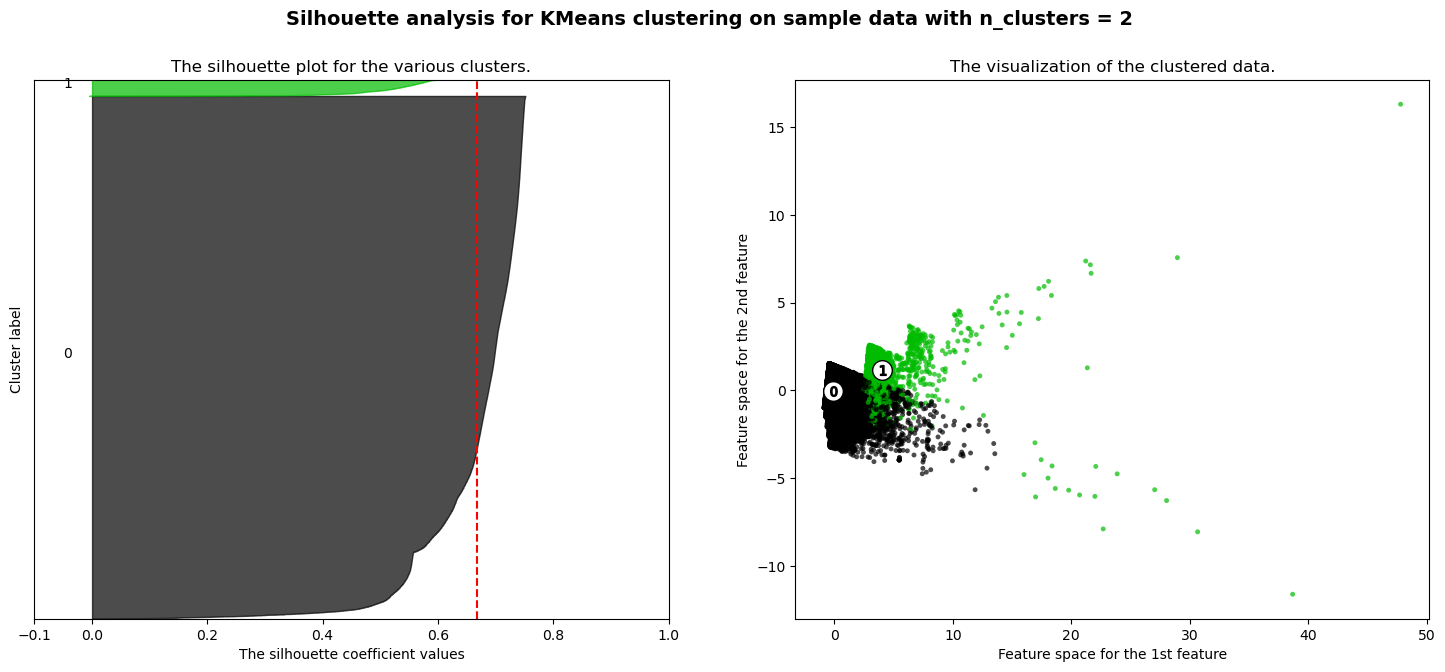

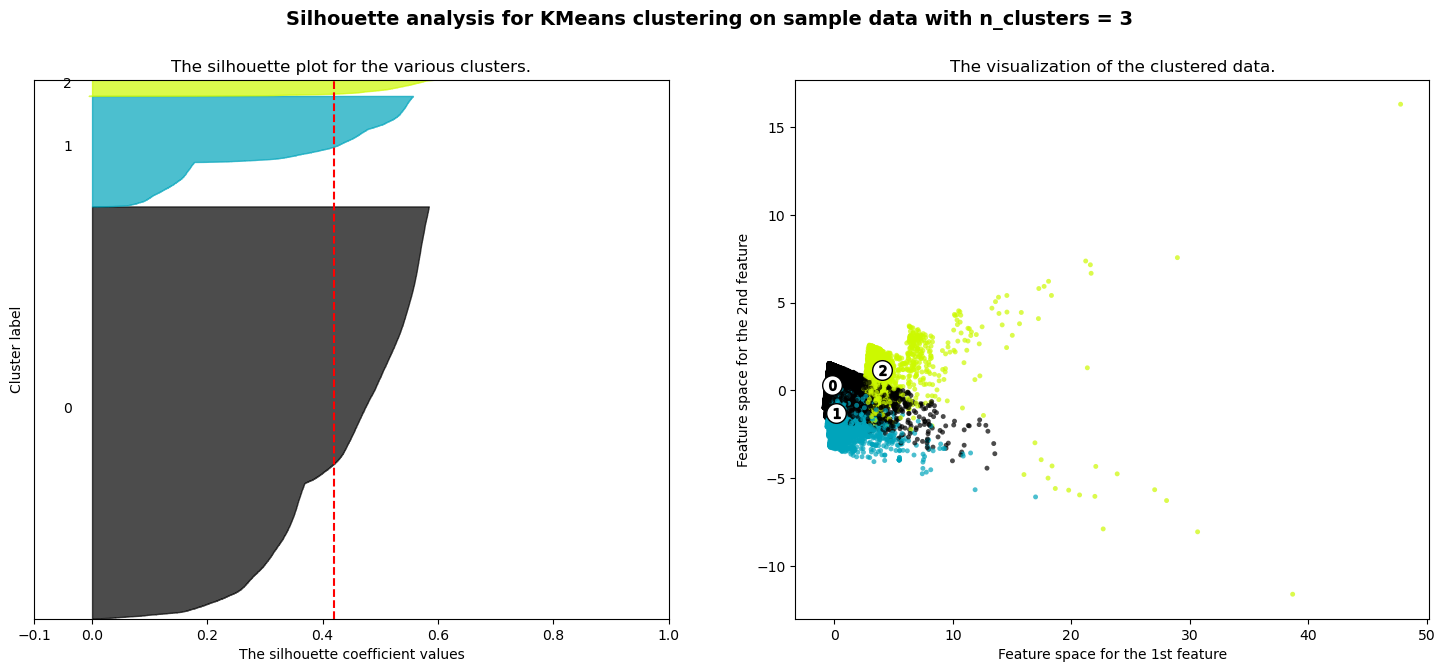

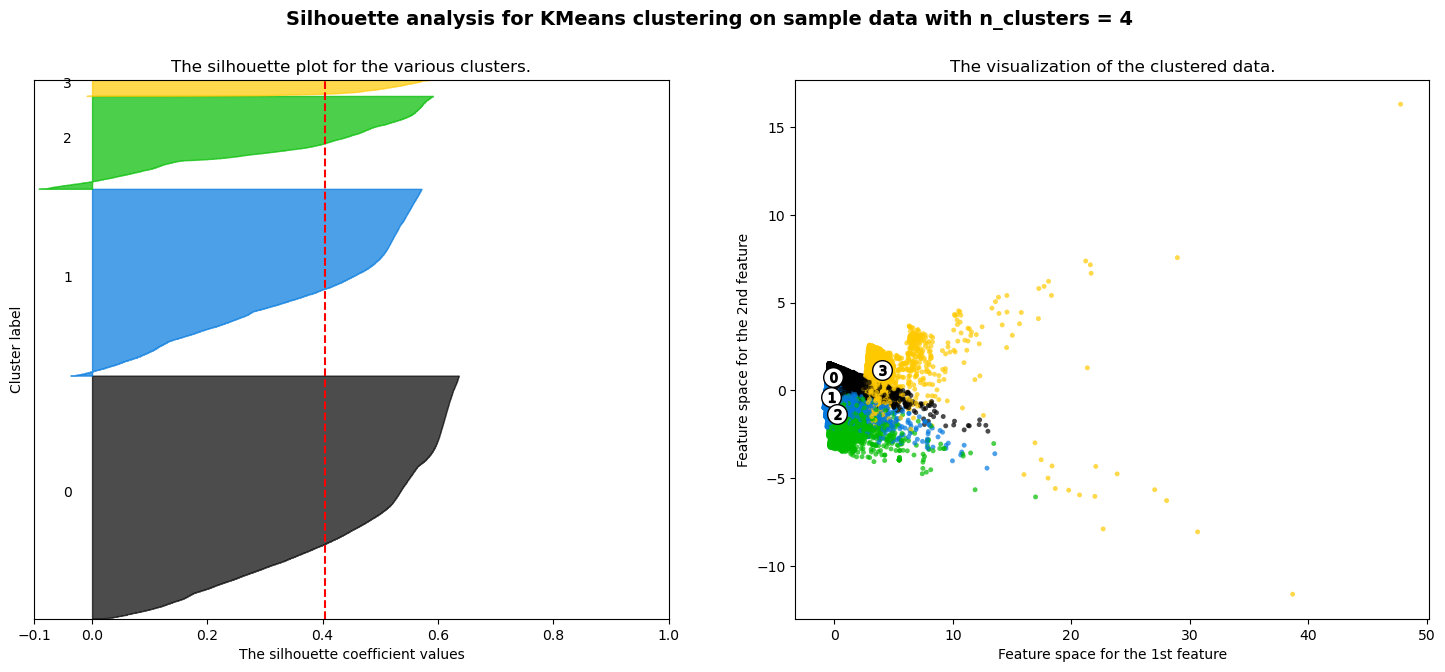

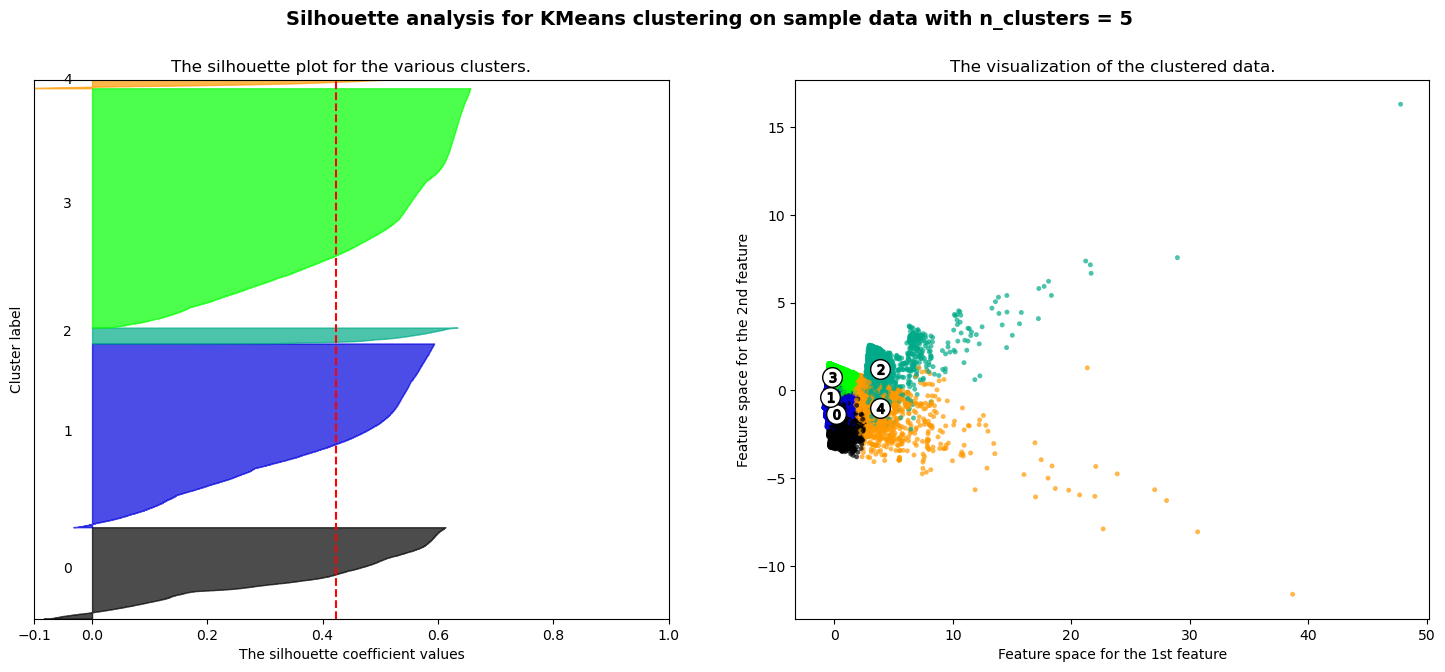

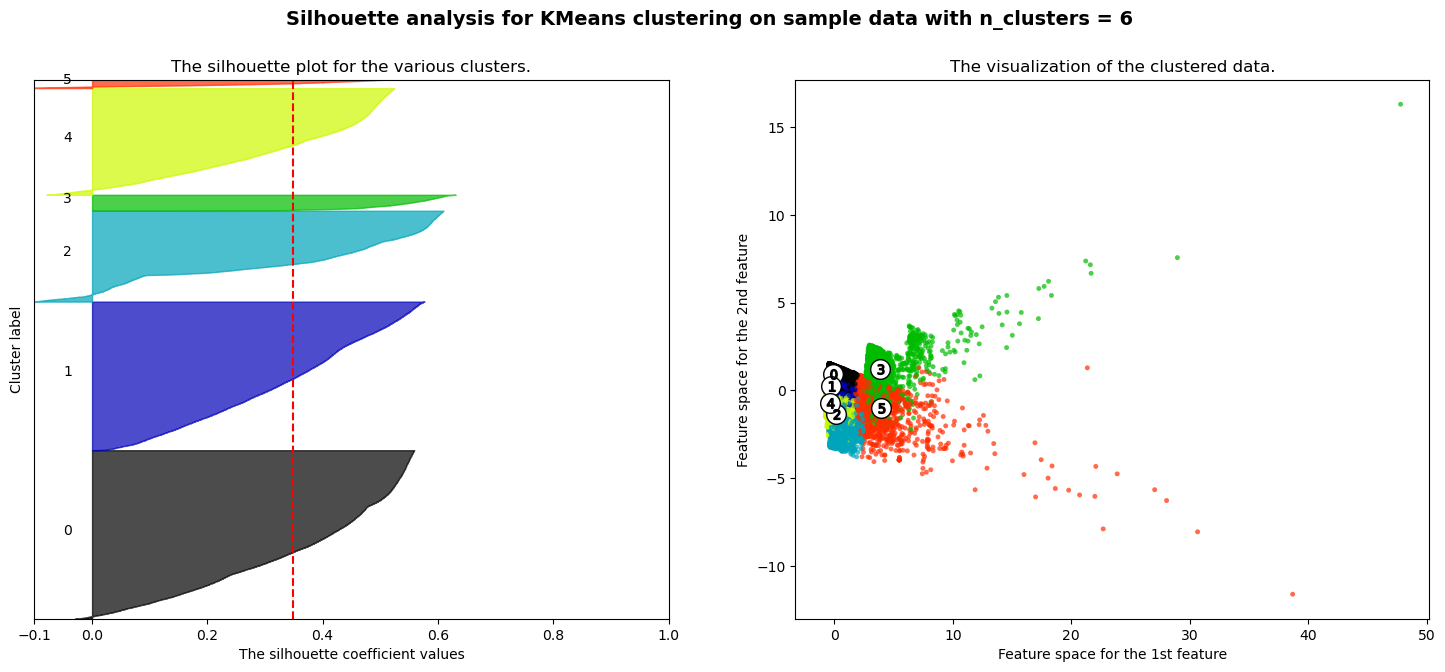

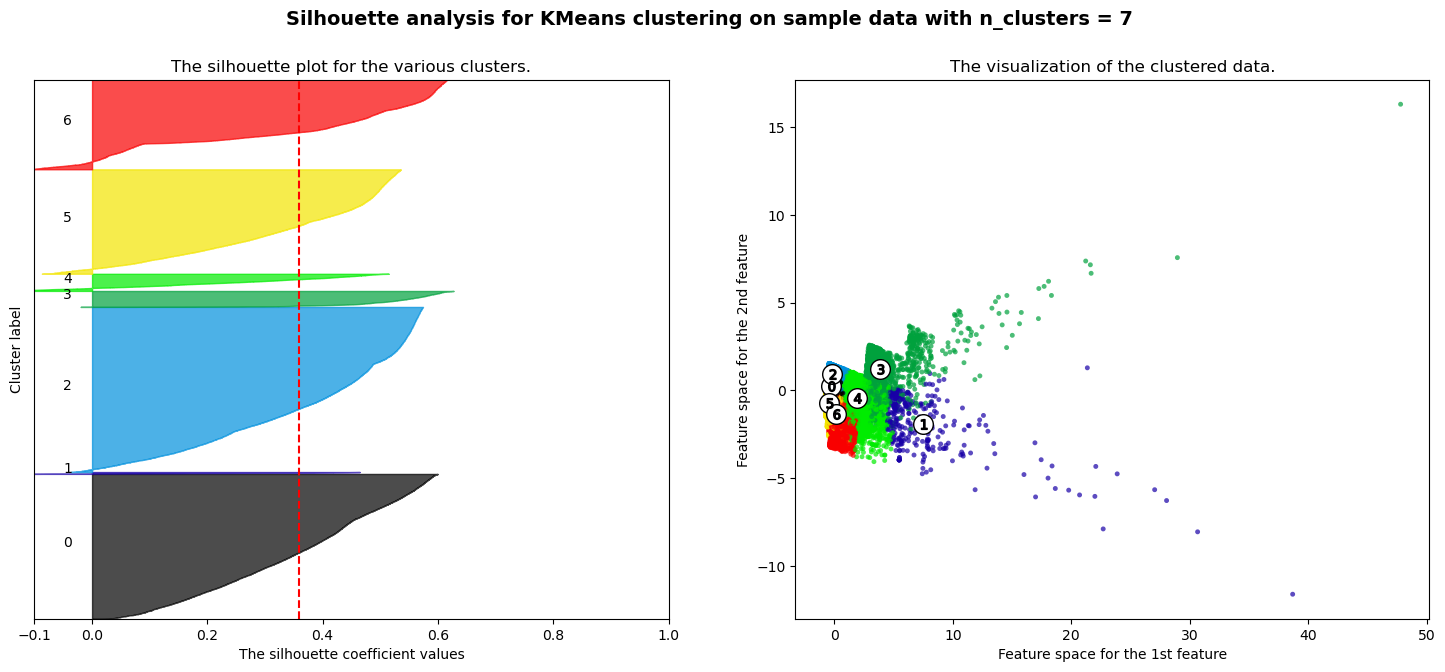

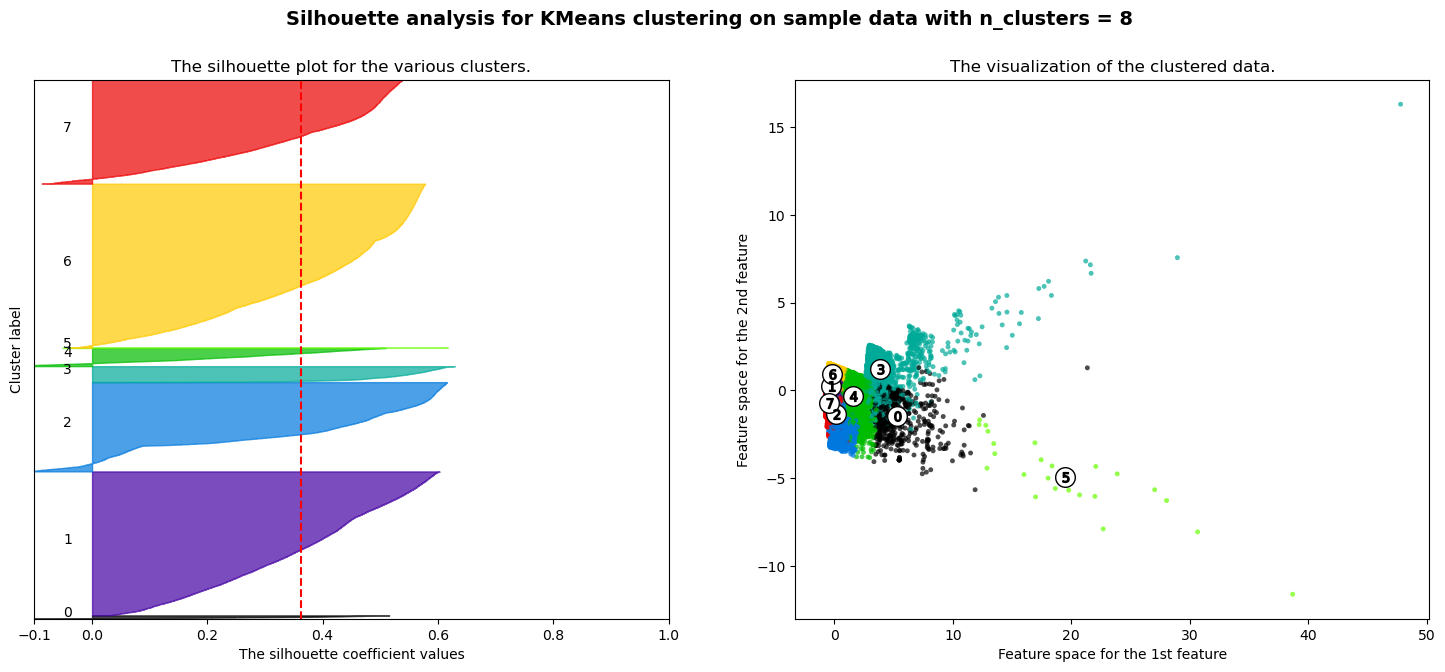

temps:_________________ 0:19:36.142060


In [17]:
debut = datetime.datetime.now()


range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
                n_clusters=n_clusters, n_init=10, random_state=None, tol=0.0001, verbose=0)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        acp_df[0], acp_df[1], marker=".", s=50, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    cent = clusterer.cluster_centers_
    centers = pca.transform(cent)
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" %
                    i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()
fin = datetime.datetime.now()
print("temps:_________________", fin-debut)

#### Clusterisation KMeans k = 4

In [18]:
n_clusters = 4

kmeans = KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
                n_clusters=n_clusters, n_init=10, random_state=None, tol=0.0001, verbose=0)

kmeans.fit(X)

y_kmeans = kmeans.fit_predict(X)

k_cent = kmeans.cluster_centers_

#### Sauvegarde du modele

In [19]:
pickle.dump(kmeans, open('kmeans_vf.pkl', 'wb'))

### Representation graphique du clustering en 2 dimensions

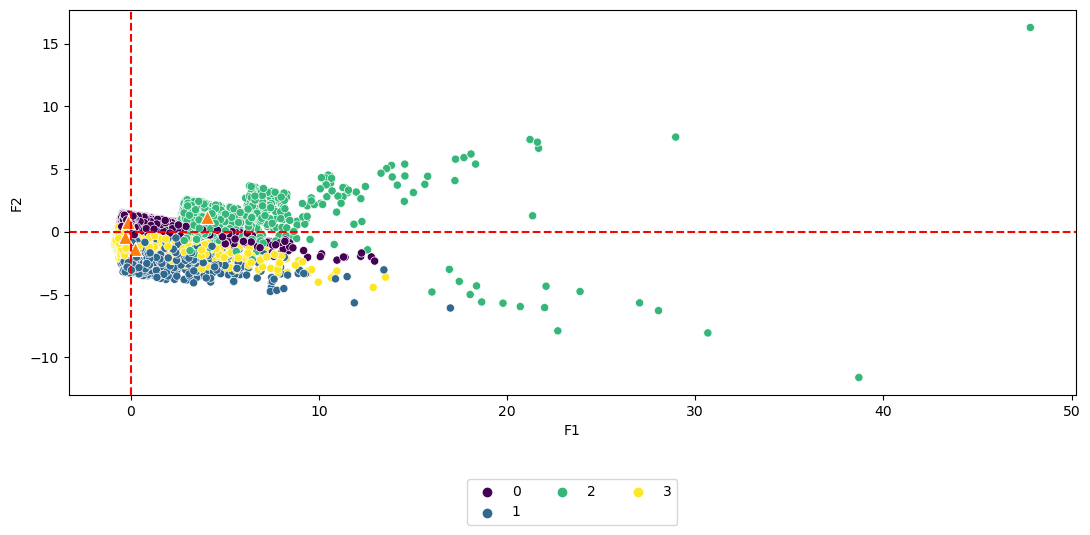

In [29]:
num_data['km_cluster'] = y_kmeans
acp_df['km_cluster'] = y_kmeans

cent = k_cent # les centroids
centers = pca.transform(cent)

x = acp_df[0]
y = acp_df[1]

fig, scatter = plt.subplots(figsize=(13, 5), dpi=100)

scatter = sns.scatterplot(x=x, y=y, data=acp_df, hue='km_cluster', s=35,
    palette='viridis')
scatter = sns.scatterplot(
    x=centers[:, 0], y=centers[:, 1], data=k_cent, s=100, marker='^')

plt.axhline(y=0, color='r', linestyle='--')
plt.axvline(x=0, color='r', linestyle='--')
plt.xlabel("F1")
plt.ylabel("F2")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.20), ncol=3)
plt.draw()

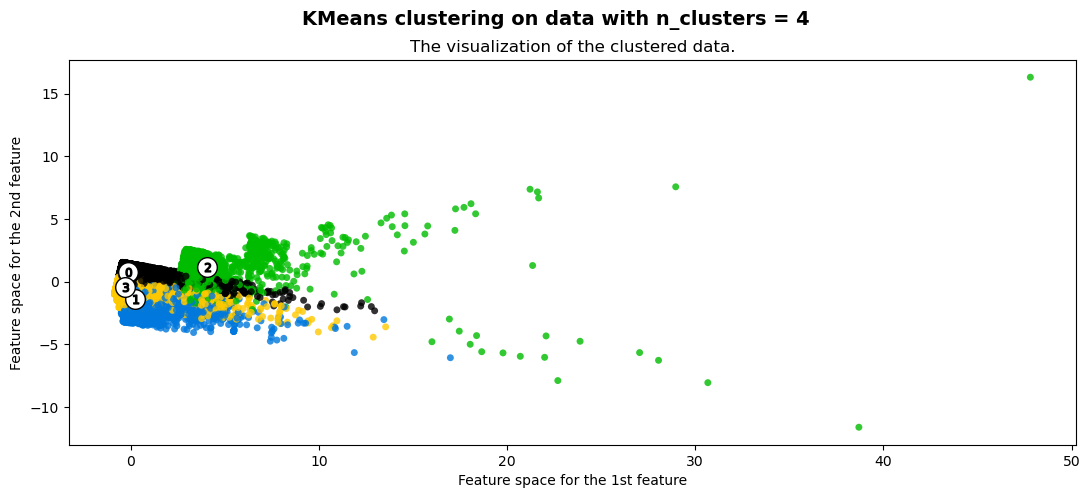

In [31]:
import matplotlib.cm as cm

fig, ax = plt.subplots()
fig.set_size_inches(13, 5)

#cluster_labels = clusterer.fit_predict(X)
cluster_labels = y_kmeans
# 2nd Plot showing the actual clusters formed
colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
ax.scatter(
    acp_df[0], acp_df[1], marker=".", s=100, lw=0, alpha=0.8, c=colors, edgecolor="k"
)

# Labeling the clusters
cent = k_cent
centers = pca.transform(cent)
# Draw white circles at cluster centers
ax.scatter(
    centers[:, 0],
    centers[:, 1],
    marker="o",
    c="white",
    alpha=1,
    s=200,
    edgecolor="k",
)

for i, c in enumerate(centers):
    ax.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=40, edgecolor="k")

ax.set_title("The visualization of the clustered data.")
ax.set_xlabel("Feature space for the 1st feature")
ax.set_ylabel("Feature space for the 2nd feature")

plt.suptitle(
    "KMeans clustering on data with n_clusters = %d"
    % n_clusters,
    fontsize=14,
    fontweight="bold",
)
plt.show()

#### Moyennes obtenues avec la clusterisation Kmeans

In [22]:
num_data.groupby('km_cluster').agg(Recency_m=('Recency', np.mean), Frequency_m=('Frequency', np.mean), Monetary_m=(
    'Monetary', np.mean), Note_moy=('note_moy', np.mean), Nb_clients=('km_cluster', len))

,Recency_m,Frequency_m,Monetary_m,Note_moy,Nb_clients
km_cluster,,,,,
0,121.509812,1.000000,136.252040,4.703474,41735
1,229.112778,1.000000,159.875650,1.725430,15934
2,219.626537,2.107737,311.793594,4.206056,2766
3,390.120428,1.000000,142.108456,4.641445,32069


#### Boxplot de la recence et du review score en fonction du groupe

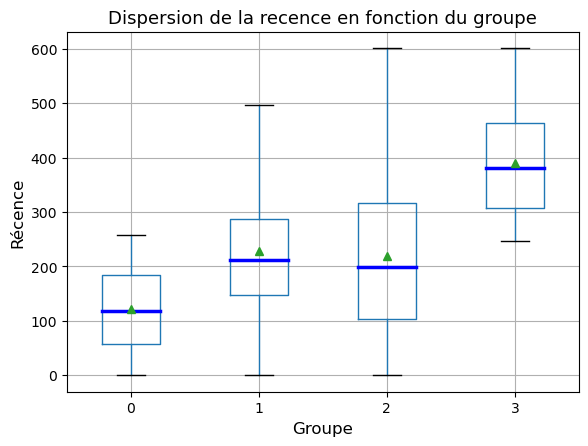

In [23]:
medianprops = dict(linestyle='-', linewidth=2.5, color='blue')
meanprops = dict(linestyle='-', linewidth=2.5, color='red')

num_data.boxplot(column="Recency", by="km_cluster",showfliers=False, medianprops=medianprops, 
             showmeans=True, meanprops=meanprops)
plt.xlabel("Groupe",color='k',fontsize=12)
plt.ylabel("Récence", color='k',fontsize=12)
plt.suptitle('')
plt.title("Dispersion de la recence en fonction du groupe", fontsize=13);

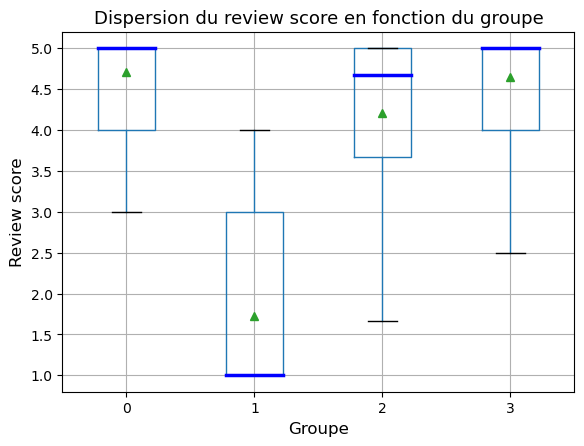

In [24]:
num_data.boxplot(column="note_moy", by="km_cluster",showfliers=False, medianprops=medianprops, 
             showmeans=True, meanprops=meanprops)
plt.xlabel("Groupe",color='k',fontsize=12)
plt.ylabel("Review score", color='k',fontsize=12)
plt.suptitle('')
plt.title("Dispersion du review score en fonction du groupe", fontsize=13);

## Maintenance

#### Chargement de l'ancien modele

In [25]:
# Ancien modèle
kmeans = pickle.load(open('kmeans_vf.pkl', 'rb'))

##### Fonction score_ari2(kmeans, maint) :

Avec l'ancien modele kmeans(kmeans) et le nombre de jours(maint) en entrées
cette fonction va entrainer les donnees avec un nouveau modele kmeans(kmeans2) sur une periode anterieure choisie
(jusqu'a 'date_model') et l appliquer pour en faire la clusterisation puis va appliquer l'ancien model kmeans(kmeans)
sur les memes données pour en faire la clusterisation, et ensuite compare les 2 predictions et affiche en sortie
le pourcentage de similarité.

remarques :   
-la periode anterieure choisie commence a la date la plus ancienne du datasaset
et fini a 'date_model' qui represente la date la plus recente du dataset + 1 jour (now)
à laquelle on SOUSTRAIT le nombre de jours(maint), soit : date_model = 30/08/2018 - maint .  
-La fonction data_sli qui permet de definir la periode choisie est utilisé dans cette fonction

In [26]:
def score_ari2(kmeans, maint):
    import datetime
    now = datetime.datetime(2018, 8, 30)
    now = pd.to_datetime(now)

    date_model = now - timedelta(days=maint)
    date_model = pd.to_datetime(date_model)

    ref_x = data_sli(date_model)

    # Centrage et Réduction
    std_scale = preprocessing.StandardScaler().fit(ref_x)
    scaled_features_seg = std_scale.transform(ref_x)

    # on initialise notre nouveau kmeans.
    kmeans2 = KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
                n_clusters=4, n_init=10, random_state=None, tol=0.0001, verbose=0).fit(scaled_features_seg)

    label_init = kmeans.predict(scaled_features_seg)  # avec l'ancien kmeans

    label_pred = kmeans2.predict(scaled_features_seg)  # avec le nouveau

    return adjusted_rand_score(label_init, label_pred)

#### Creation d'une boucle permetant de creer un dataset contenant le pourcentage de similarités obtenus avec score_ari2 sur 1 an

In [27]:
days = []
pourcent = []

for i in range(1, 366):
    y = (score_ari2(kmeans, i)) * 100
    days.append(i)
    pourcent.append(y)

df_maint = pd.DataFrame()
df_maint['jour'] = days
df_maint['pourcentage'] = pourcent

#### Graphique illustrant le poucentage de validité du modele en fonction du nombre de jours ecoulés

Nb de jours pour une maintenance a 90% de validité du modèle : 24 .
Nb de jours pour une maintenance a 85% de validité du modèle : 128 .


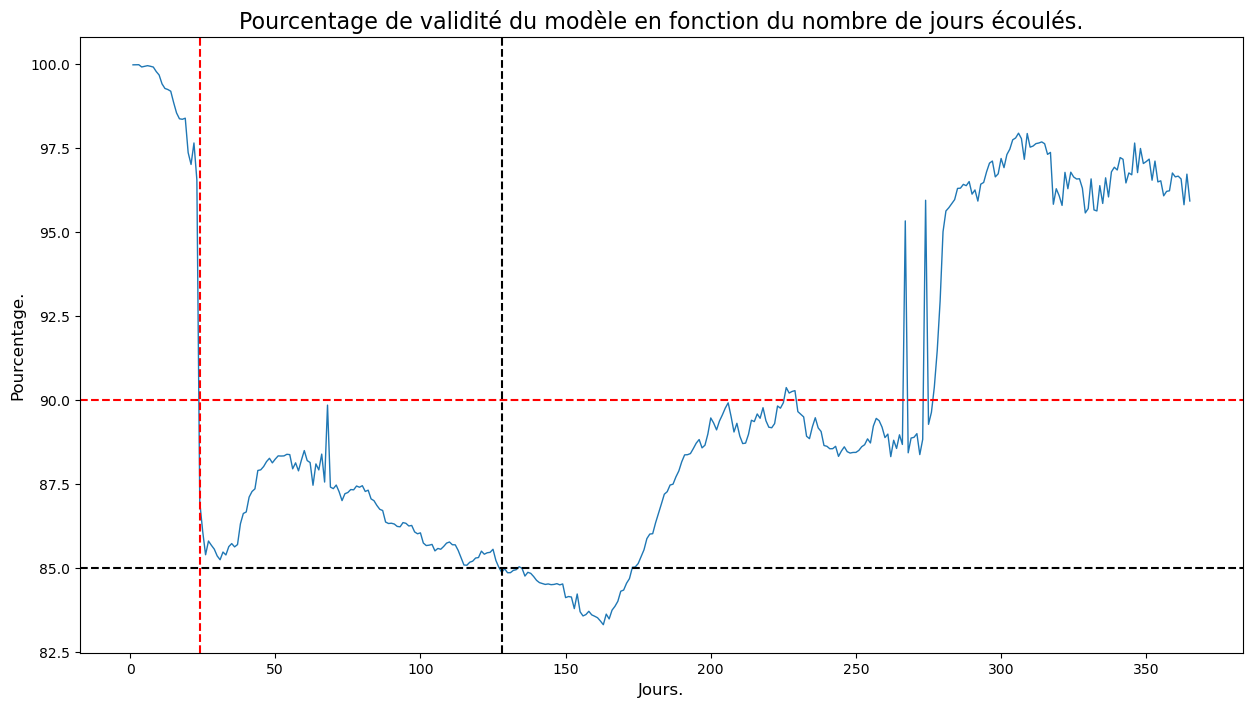

In [28]:
plt.figure(figsize=(15, 8))

b = df_maint[df_maint.pourcentage <= 90].iloc[0, :][0]  # maintenance a 90%
a = df_maint[df_maint.pourcentage <= 85].iloc[0, :][0]  # maintenance a 85%

plt.plot(df_maint['jour'],  df_maint['pourcentage'], lw=1)
plt.axhline(y=85, color='k', linestyle='--')
plt.axhline(y=90, color='r', linestyle='--')
plt.axvline(x=a, color='k', linestyle='--')
plt.axvline(x=b, color='r', linestyle='--')

plt.xlabel("Jours.",color='k',fontsize=12)
plt.ylabel("Pourcentage.", color='k',fontsize=12)
plt.title("Pourcentage de validité du modèle en fonction du nombre de jours écoulés.", fontsize=16)

print("Nb de jours pour une maintenance a 90% de validité du modèle :", int(b), ".")
print("Nb de jours pour une maintenance a 85% de validité du modèle :", int(a), ".")
plt.draw()